In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option("display.max_columns", 300)
pd.set_option("display.width", 500)

plt.rcParams["figure.figsize"] = (8, 6)
fontsize = 14

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'
%load_ext lab_black

In [6]:
from prophet import Prophet


def prepare_model_and_data(scores_df, freq="15T"):
    prophet_df = scores_df.copy()
    prophet_df.resample("15T", on="time").mean()
    prophet_df.rename(columns={"time": "ds", "score": "y"}, inplace=True)
    prophet_df["ds"] = pd.to_datetime(prophet_df["ds"])
    m = Prophet().fit(prophet_df)
    return prophet_df, m


def predict_period(
    prophet_model, period="1D", start=None, freq="15T", normalize_score=True
):
    start = pd.to_datetime("today").date() if not start else start
    pred_dates = pd.date_range(
        start=start,
        end=start + pd.Timedelta(period),
        freq=freq,
    )
    pred_dates = pred_dates.to_frame(index=False, name="ds")
    forecast = prophet_model.predict(pred_dates)
    if normalize_score:
        forecast["yhat"] = forecast["yhat"].clip(0, 1)
        forecast["yhat_lower"] = forecast["yhat_lower"].clip(0, 1)
        forecast["yhat_upper"] = forecast["yhat_upper"].clip(0, 1)
    return forecast

In [3]:
dates = pd.date_range(start="2023-02-10", end="2023-03-10", freq="5T")
scores_df = dates.to_frame(index=False, name="time")
scores_df["score"] = np.cos(2 * np.pi * scores_df["time"].dt.hour / 16)
scores_df["score"] = (scores_df["score"] - scores_df["score"].min()) / (
    scores_df["score"].max() - scores_df["score"].min()
)
scores_df["score"] = scores_df["score"] > scores_df["score"].mean()

In [4]:
prophet_df, model = prepare_model_and_data(scores_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/Users/maximkurkin/miniconda3/envs/moscow_zoo/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -2186.02
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        9393.1   0.000302723       101.114      0.6326      0.6326      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     163       9393.18   3.37196e-07       80.5806      0.3845           1      205   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/maximkurkin/miniconda3/envs/moscow_zoo/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/maximkurkin/miniconda3/envs/moscow_zoo/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


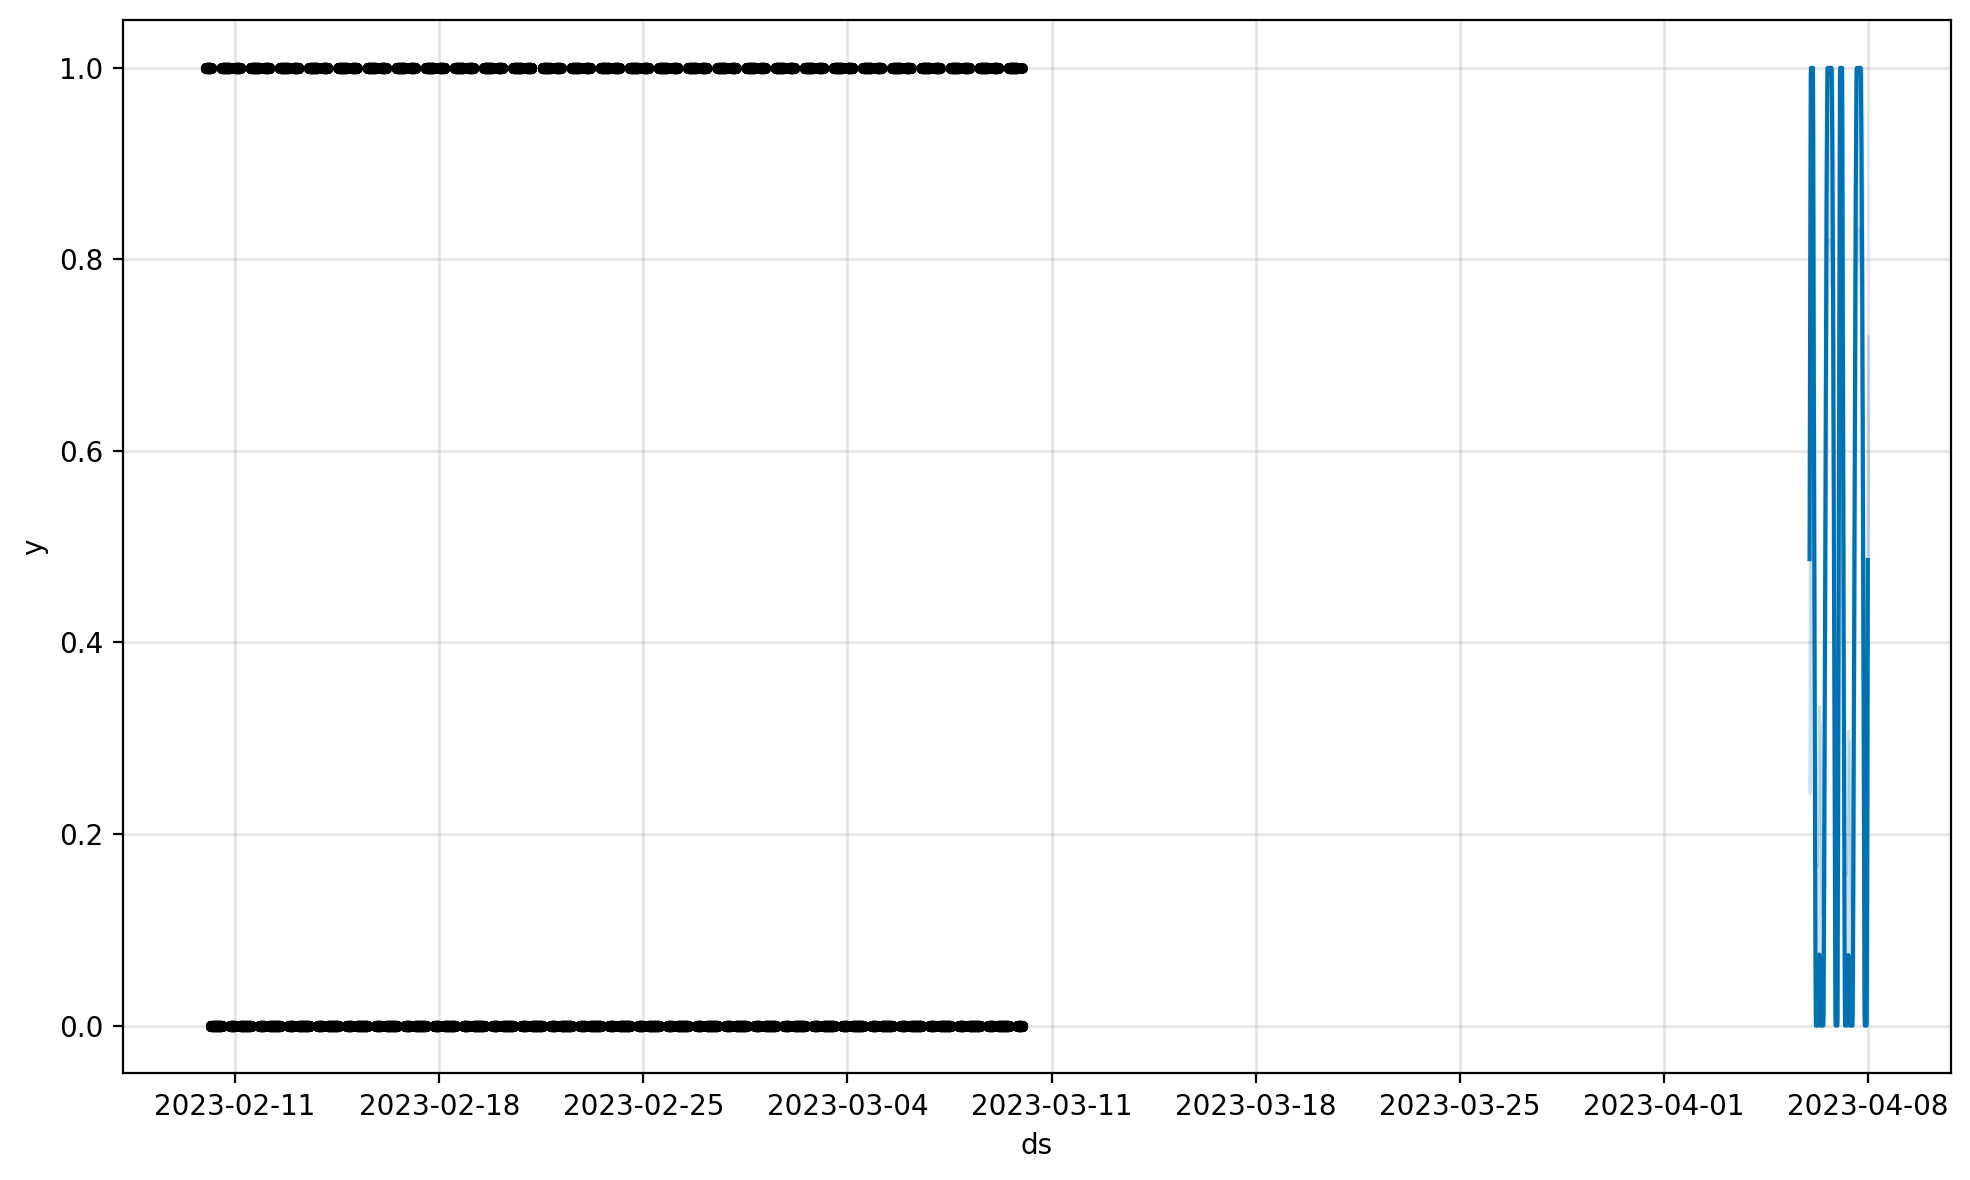

In [7]:
pred = predict_period(model, "48H")
fig = model.plot(pred)

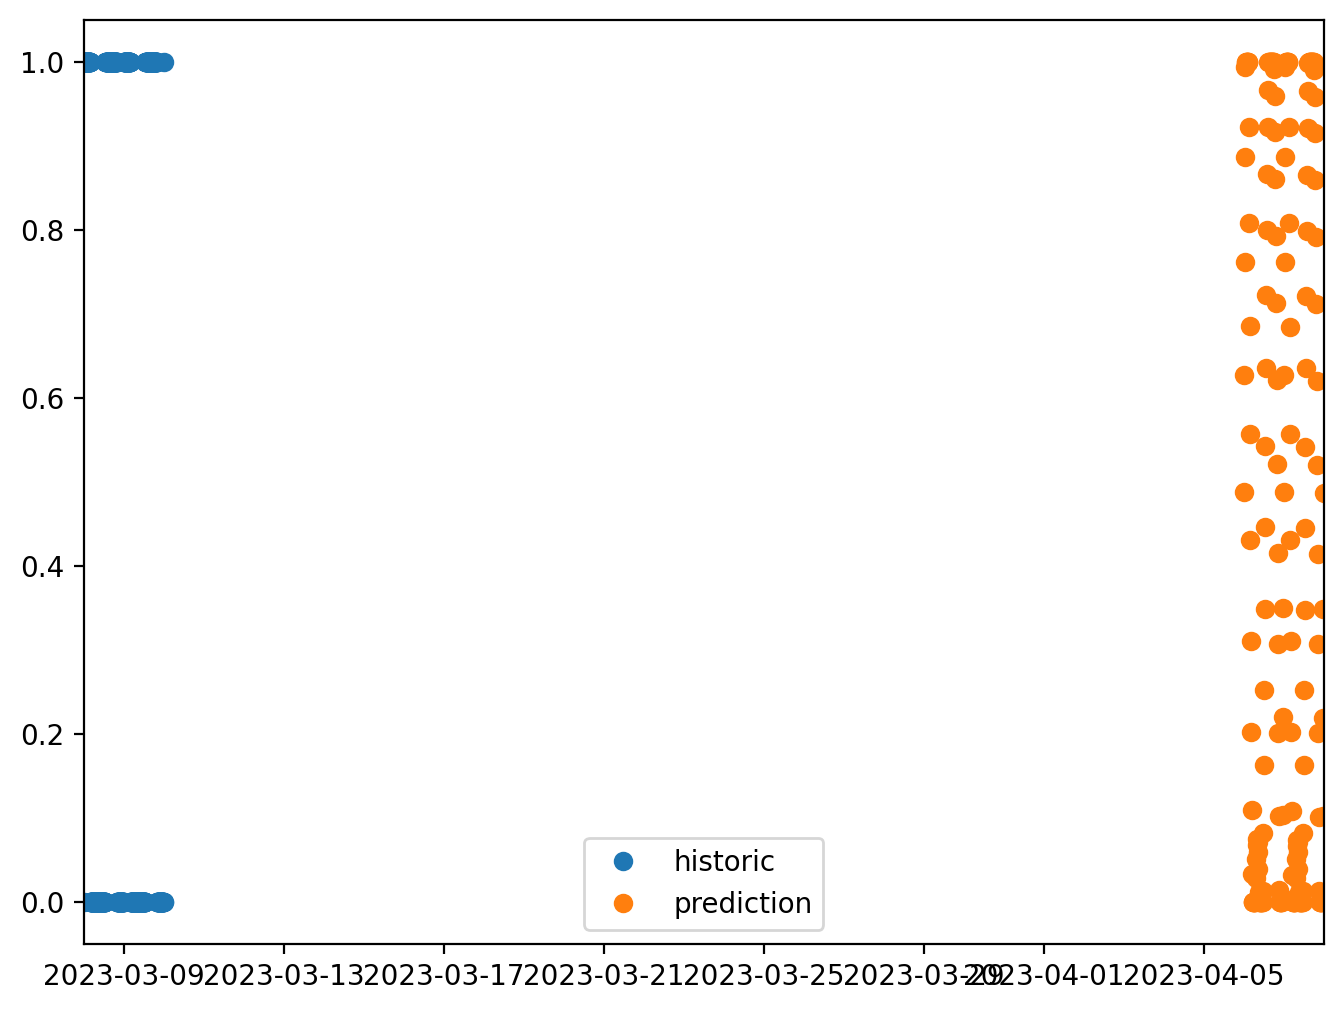

In [8]:
plt.plot_date(prophet_df["ds"], prophet_df["y"], label="historic")
plt.plot_date(pred["ds"], pred["yhat"], label="prediction")
plt.legend()
plt.xlim([prophet_df["ds"].max() - pd.Timedelta(days=2), pred["ds"].max()])
plt.show()

In [9]:
from prophet.serialize import model_to_json, model_from_json

with open("prophet_model.json", "w") as fout:
    fout.write(model_to_json(model))  # Save model

with open("prophet_model.json", "r") as fin:
    model = model_from_json(fin.read())  # Load model

/Users/maximkurkin/miniconda3/envs/moscow_zoo/lib/python3.8/site-packages/prophet/serialize.py:136: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(attr_dict[attribute]))


In [11]:
pred[["ds", "yhat"]]

,ds,yhat
0,2023-04-06 00:00:00,0.487113
1,2023-04-06 00:15:00,0.626774
2,2023-04-06 00:30:00,0.761798
3,2023-04-06 00:45:00,0.885957
4,2023-04-06 01:00:00,0.993517
...,...,...
188,2023-04-07 23:00:00,0.004411
189,2023-04-07 23:15:00,0.102059
190,2023-04-07 23:30:00,0.218318
191,2023-04-07 23:45:00,0.348256
